In [1]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from branca.element import Template, MacroElement


# Using the NYC Open Data to get 'Noise' complaints from 311
# Define the path to your new 2025/2026 data

df_new = pd.read_csv('../Data/Noise_2025_Filtered3.csv', low_memory=False)

# Convert 'Created Date' to datetime so we can filter for just 2025
df_new['created_date'] = pd.to_datetime(df_new['created_date'])
df_2025 = df_new[df_new['created_date'].dt.year == 2025]


# 2. Filtering for Noise immediately to save memory
noise_df = df_2025[df_2025['complaint_type'].str.contains('Noise', case=False, na=False)].copy()

# 3. Clean missing coordinates
noise_df = noise_df.dropna(subset=['latitude', 'longitude'])

# Converting the Latitude/Longitude into a 'Geography' format
gdf = gpd.GeoDataFrame(
    noise_df, geometry=gpd.points_from_xy(noise_df.longitude, noise_df.latitude), crs="EPSG:4326"
)

print(f"Successfully loaded {len(gdf)} noise complaints!")
print(f"Total Noise Complaints in 2015: 118,000 (approx)")
print(f"Total Noise Complaints in 2025: {len(gdf):,}")
gdf.head()

Successfully loaded 829948 noise complaints!
Total Noise Complaints in 2015: 118,000 (approx)
Total Noise Complaints in 2025: 829,948


unique_key        created_date              closed_date agency  \
0    67351762 2025-12-31 23:59:28  2026-01-01T00:40:32.000   NYPD   
1    67344624 2025-12-31 23:59:23  2026-01-01T01:03:42.000   NYPD   
2    67353004 2025-12-31 23:59:20  2026-01-01T00:57:31.000   NYPD   
3    67350526 2025-12-31 23:59:12  2026-01-01T00:41:16.000   NYPD   
4    67349434 2025-12-31 23:59:08  2026-01-01T00:44:09.000   NYPD   

                       agency_name       complaint_type        descriptor  \
0  New York City Police Department  Noise - Residential  Loud Music/Party   
1  New York City Police Department  Noise - Residential  Loud Music/Party   
2  New York City Police Department  Noise - Residential  Loud Music/Party   
3  New York City Police Department   Noise - Commercial  Loud Music/Party   
4  New York City Police Department  Noise - Residential  Loud Music/Party   

  descriptor_2               location_type  incident_zip  ...  \
0          NaN  Residential Building/House       10029.0  ...   
1          NaN  Residential Building/House       10031.0  ...   
2          NaN  Residential Building/House       11235.0  ...   
3          NaN            Store/Commercial       10031.0  ...   
4          NaN  Residential Building/House       11234.0  ...   

  taxi_company_borough taxi_pick_up_location bridge_highway_name  \
0                  NaN                   NaN                 NaN   
1                  NaN                   NaN                 NaN   
2                  NaN                   NaN                 NaN   
3                  NaN                   NaN                 NaN   
4                  NaN                   NaN                 NaN   

  bridge_highway_direction road_ramp bridge_highway_segment   latitude  \
0                      NaN       NaN                    NaN  40.792141   
1                      NaN       NaN                    NaN  40.825137   
2                      NaN       NaN                    NaN  40.591542   
3                      NaN       NaN                    NaN  40.822593   
4                      NaN       NaN                    NaN  40.629373   

   longitude                                  location  \
0 -73.950097  POINT (-73.950097072847 40.792140506424)   
1 -73.949447   POINT (-73.949447237231 40.82513729001)   
2 -73.955979  POINT (-73.955979130812 40.591541524842)   
3 -73.949525  POINT (-73.949525045155 40.822592971648)   
4 -73.928005  POINT (-73.928004925688 40.629372641946)   

                     geometry  
0   POINT (-73.9501 40.79214)  
1  POINT (-73.94945 40.82514)  
2  POINT (-73.95598 40.59154)  
3  POINT (-73.94953 40.82259)  
4    POINT (-73.928 40.62937)  

[5 rows x 45 columns]

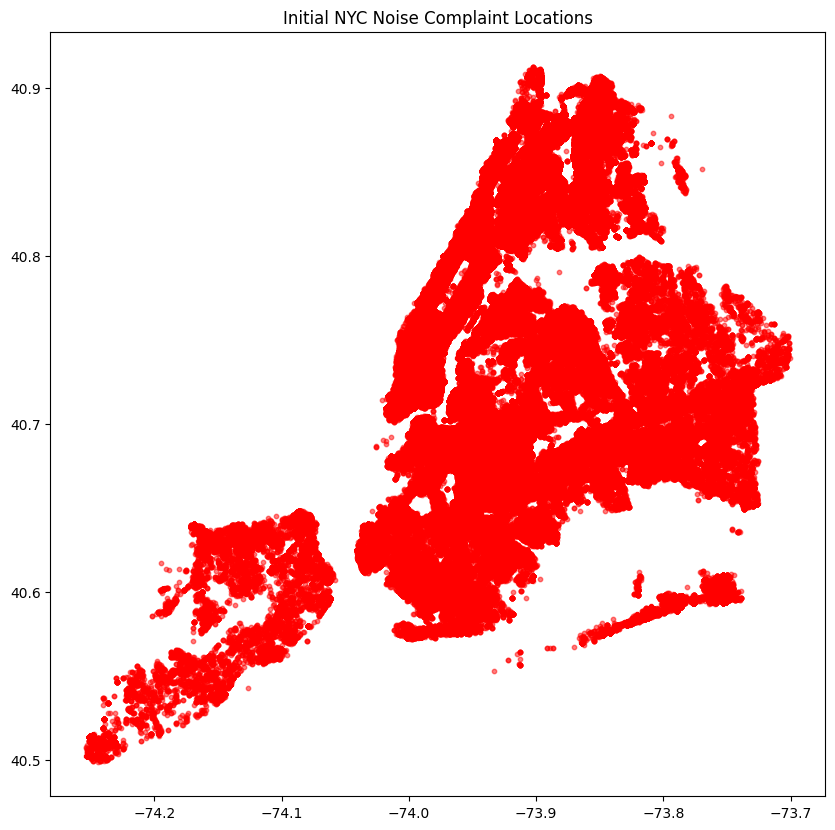

In [2]:
# Create a quick plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, alpha=0.5, markersize=10, color='red')

ax.set_title("Initial NYC Noise Complaint Locations")
plt.show()

In [3]:
## Determining the Total Nighttime Noise Events
## Since our project title is Noise Pollution & Sleep Quality, we don't care about a lawnmower at 2:00 PM as much as we care about loud music at 2:00 AM.
## Let's filter for the "Sleep Risk Zone" (11:00 PM to 5:00 AM):

# Convert 'Created Date' to a real datetime format
noise_df['created_date'] = pd.to_datetime(noise_df['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Extract the hour (0-23)
noise_df['hour'] = noise_df['created_date'].dt.hour

# Filter for Nighttime: 11 PM (23) to 5 AM (5)
night_noise = noise_df[(noise_df['hour'] >= 23) | (noise_df['hour'] <= 5)]

print(f"Total Nighttime Noise Events: {len(night_noise)}")
gdf.head()

Total Nighttime Noise Events: 279244


unique_key        created_date              closed_date agency  \
0    67351762 2025-12-31 23:59:28  2026-01-01T00:40:32.000   NYPD   
1    67344624 2025-12-31 23:59:23  2026-01-01T01:03:42.000   NYPD   
2    67353004 2025-12-31 23:59:20  2026-01-01T00:57:31.000   NYPD   
3    67350526 2025-12-31 23:59:12  2026-01-01T00:41:16.000   NYPD   
4    67349434 2025-12-31 23:59:08  2026-01-01T00:44:09.000   NYPD   

                       agency_name       complaint_type        descriptor  \
0  New York City Police Department  Noise - Residential  Loud Music/Party   
1  New York City Police Department  Noise - Residential  Loud Music/Party   
2  New York City Police Department  Noise - Residential  Loud Music/Party   
3  New York City Police Department   Noise - Commercial  Loud Music/Party   
4  New York City Police Department  Noise - Residential  Loud Music/Party   

  descriptor_2               location_type  incident_zip  ...  \
0          NaN  Residential Building/House       10029.0  ...   
1          NaN  Residential Building/House       10031.0  ...   
2          NaN  Residential Building/House       11235.0  ...   
3          NaN            Store/Commercial       10031.0  ...   
4          NaN  Residential Building/House       11234.0  ...   

  taxi_company_borough taxi_pick_up_location bridge_highway_name  \
0                  NaN                   NaN                 NaN   
1                  NaN                   NaN                 NaN   
2                  NaN                   NaN                 NaN   
3                  NaN                   NaN                 NaN   
4                  NaN                   NaN                 NaN   

  bridge_highway_direction road_ramp bridge_highway_segment   latitude  \
0                      NaN       NaN                    NaN  40.792141   
1                      NaN       NaN                    NaN  40.825137   
2                      NaN       NaN                    NaN  40.591542   
3                      NaN       NaN                    NaN  40.822593   
4                      NaN       NaN                    NaN  40.629373   

   longitude                                  location  \
0 -73.950097  POINT (-73.950097072847 40.792140506424)   
1 -73.949447   POINT (-73.949447237231 40.82513729001)   
2 -73.955979  POINT (-73.955979130812 40.591541524842)   
3 -73.949525  POINT (-73.949525045155 40.822592971648)   
4 -73.928005  POINT (-73.928004925688 40.629372641946)   

                     geometry  
0   POINT (-73.9501 40.79214)  
1  POINT (-73.94945 40.82514)  
2  POINT (-73.95598 40.59154)  
3  POINT (-73.94953 40.82259)  
4    POINT (-73.928 40.62937)  

[5 rows x 45 columns]

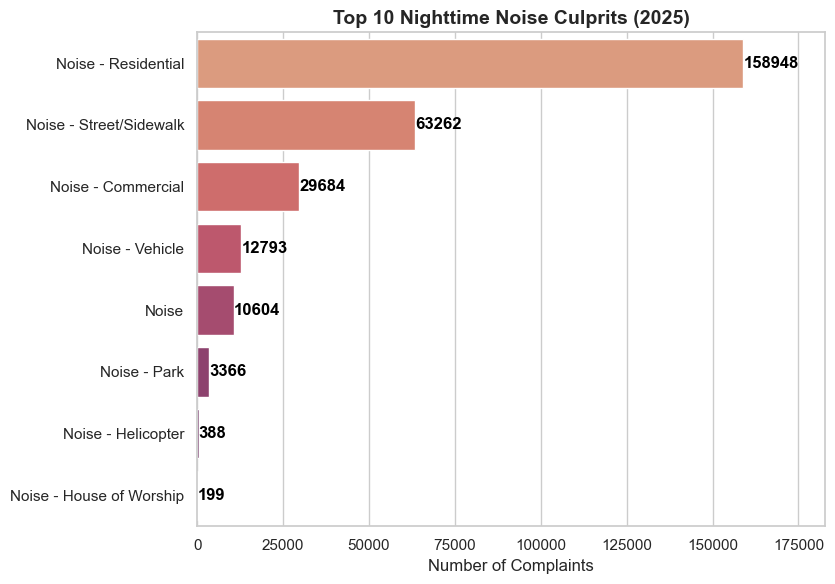

--- 2025 NIGHTTIME CULPRITS (11PM - 5AM) ---
complaint_type
Noise - Residential         158948
Noise - Street/Sidewalk      63262
Noise - Commercial           29684
Noise - Vehicle              12793
Noise                        10604
Noise - Park                  3366
Noise - Helicopter             388
Noise - House of Worship       199
Name: count, dtype: int64

--- 2025 GENERAL NIGHTTIME HOTSPOTS (Zip Codes) ---
incident_zip
10466.0    35308
10452.0     5135
10456.0     5047
11368.0     4726
10031.0     4579
10002.0     4377
11206.0     4208
10029.0     3996
10032.0     3924
11237.0     3898
Name: count, dtype: int64


In [4]:
## General Night time complains and culprits
# 1. What are people complaining about at 2 AM?
night_types = night_noise['complaint_type'].value_counts().head(10).copy()

# 2. Where is the sleep disruption worst? (Top 5 General Nighttime Zips) (All noise types)
night_zips = night_noise['incident_zip'].value_counts().head(10)


# Set the style for a professional "Data Journal" look
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# 1. Visualization for Nighttime Complaint Types
plt.subplot(1, 2, 1) # Left side
sns.barplot(x=night_types.values, y=night_types.index, hue=night_types.index, palette="flare", legend=False)
plt.title('Top 10 Nighttime Noise Culprits (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Complaints')
plt.ylabel('')

# Add data labels on top of bars
for i, v in enumerate(night_types.values):
    # x = v + offset, y = i
    plt.text(v + 50, i, str(v), va='center', fontweight='bold', color='black')

# Adjust x-axis limit slightly so labels don't get cut off
plt.xlim(0, max(night_types.values) * 1.15)
# Final layout adjustment
plt.tight_layout()
plt.show()

print("--- 2025 NIGHTTIME CULPRITS (11PM - 5AM) ---")
print(night_types)

print("\n--- 2025 GENERAL NIGHTTIME HOTSPOTS (Zip Codes) ---")
print(night_zips)


In [5]:
# Specific Residential Nighttime Hotspots
# We filter the night_noise specifically for 'Noise - Residential'
residential_night = night_noise[night_noise['complaint_type'] == 'Noise - Residential']
res_night_zips = residential_night['incident_zip'].value_counts().head(10)

print("\n--- 2025 RESIDENTIAL-ONLY NIGHTTIME HOTSPOTS ---")
print(res_night_zips)


--- 2025 RESIDENTIAL-ONLY NIGHTTIME HOTSPOTS ---
incident_zip
10466.0    34695
10456.0     3224
10467.0     2484
10452.0     2206
11207.0     2173
10029.0     2104
11221.0     2037
11233.0     2022
10468.0     2015
10458.0     1901
Name: count, dtype: int64


In [6]:
# Check where the 2015 'Noise King' stands in 2025
inwood_count = night_noise[night_noise['incident_zip'] == 10034].shape[0]
rank_2025 = (night_noise['incident_zip'].value_counts().index == 10034).argmax() + 1

print(f"In 2015, 10034 was #1.")
print(f"In 2025, 10034 has {inwood_count} nighttime complaints and is ranked #{rank_2025}.")

In 2015, 10034 was #1.
In 2025, 10034 has 2921 nighttime complaints and is ranked #26.


C:\Users\Maggie Williams\AppData\Local\Temp\ipykernel_7520\594316729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  night_noise['Hour'] = pd.to_datetime(night_noise['created_date']).dt.hour


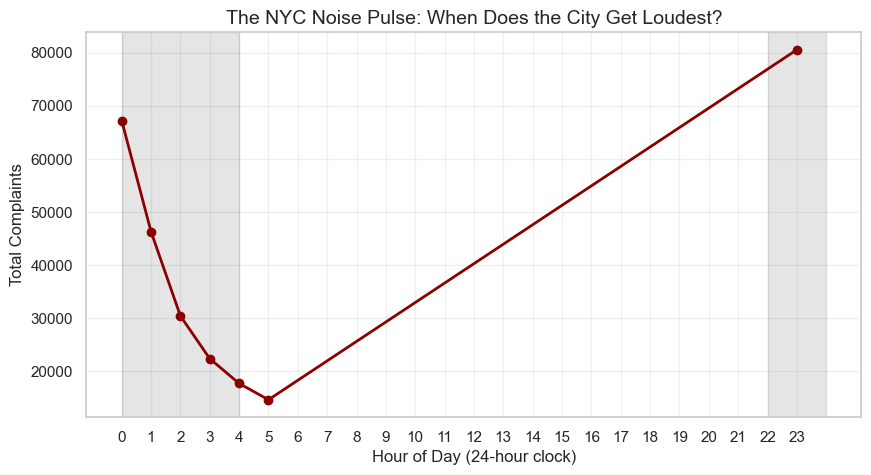

In [7]:
# General night noise trend
# Creating an 'Hour' column from the Created Date
# We use .dt.hour to see exactly when people start calling 311
night_noise['Hour'] = pd.to_datetime(night_noise['created_date']).dt.hour

# Group by hour to see the city's 'Noise Pulse'
hourly_trend = night_noise.groupby('Hour').size()

# Plot the 'Pulse' of the City
plt.figure(figsize=(10, 5))
plt.plot(hourly_trend.index, hourly_trend.values, marker='o', color='darkred', linewidth=2)

plt.title('The NYC Noise Pulse: When Does the City Get Loudest?', fontsize=14)
plt.xlabel('Hour of Day (24-hour clock)', fontsize=12)
plt.ylabel('Total Complaints', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.axvspan(22, 24, color='gray', alpha=0.2, label='Peak Nightlife Start')
plt.axvspan(0, 4, color='black', alpha=0.1)

plt.show()

In [8]:
# General Night Noise interactive map
## Interactive Heatmap showing which blocks are the "Sleep Killers."


# 1. Creating a base map centered on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='cartodbpositron')

# 2. Prepare the data (Latitude, Longitude) for the HeatMap
# We'll take a sample of 10,000 for performance
heat_data = [[row['latitude'], row['longitude']] for index, row in night_noise.sample(10000).iterrows()]

# 3. Add the HeatMap layer
HeatMap(heat_data, radius=10, blur=15).add_to(m)

# 4. Save and view
m.save('nyc_general_sleep_risk_map_2025.html')
m

In [9]:
# 1. Filter specifically for Commercial Noise only
comm_noise = night_noise[night_noise['complaint_type'].str.contains('Commercial', case=False, na=False)].copy()

# 2. Get the Top 10 Zip Codes for Commercial Noise specifically
# We convert to string and strip to handle any formatting issues
comm_noise['incident_zip'] = comm_noise['incident_zip'].astype(str).str.strip().str.replace('.0', '', regex=False)
top_10_zips = comm_noise['incident_zip'].value_counts().head(10)

# 3. PRINT the results for the records
print("--- Top 10 Commercial Noise Hotspots (11 PM - 5 AM) ---")
print(top_10_zips)

--- Top 10 Commercial Noise Hotspots (11 PM - 5 AM) ---
incident_zip
10002    1438
11206    1177
11385    1028
11211    1019
11103     919
11237     868
11372     651
10031     628
10011     614
10009     568
Name: count, dtype: int64


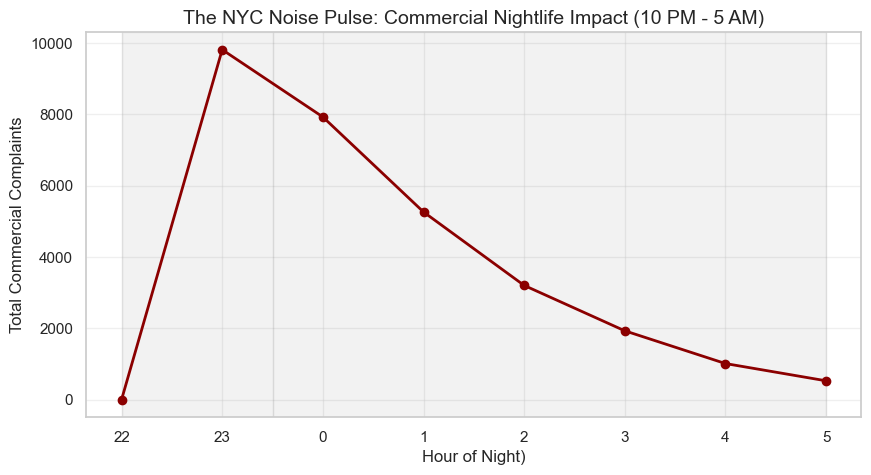

In [10]:
## Commercial noise pulse
# Creating an 'Hour' column from the Created Date
# We use .dt.hour to see exactly when people start calling 311
# Filter for the specific hours (22, 23, 0, 1, 2, 3, 4, 5)
night_hours = [22, 23, 0, 1, 2, 3, 4, 5]
comm_noise['Hour'] = pd.to_datetime(comm_noise['created_date']).dt.hour
comm_night_only = comm_noise[comm_noise['Hour'].isin(night_hours)]


# Group by hour to see the city's 'Noise Pulse'
# We use a categorical sort so 23 leads into 0 correctly
comm_night_only['Hour'] = pd.Categorical(comm_night_only['Hour'], categories=night_hours, ordered=True)
comm_hourly_trend = comm_night_only.groupby('Hour', observed=True).size().reindex(night_hours, fill_value=0)


# Plot the 'Pulse' of the City
plt.figure(figsize=(10, 5))
plt.plot(range(len(night_hours)), comm_hourly_trend.values, marker='o', color='darkred', linewidth=2)

plt.title('The NYC Noise Pulse: Commercial Nightlife Impact (10 PM - 5 AM)', fontsize=14)
plt.xlabel('Hour of Night)', fontsize=12)
plt.ylabel('Total Commercial Complaints', fontsize=12)
plt.xticks(range(len(night_hours)), night_hours)
plt.grid(True, alpha=0.3)
plt.axvspan(0, 1.5, color='gray', alpha=0.1, label='Pre-Midnight')# 10 PM - Midnight
plt.axvspan(1.5, 7, color='black', alpha=0.05, label='Post-Midnight')# Midnight - 5 AM

plt.show()

In [20]:
# 1. Create a dictionary of names for Zip Codes
neighborhood_map = {
    # --- 2025 RESIDENTIAL-ONLY HOTSPOTS ---
    "10466": "Wakefield (Bronx)",
    "10456": "Morrisania (Bronx)",
    "10468": "Fordham (Bronx)",
    "10029": "East Harlem (Manhattan)",
    "10467": "Williamsbridge (Bronx)",
    "10452": "Highbridge (Bronx)",
    "11207": "East New York (Brooklyn)",
    "11221": "Bushwick / Bedford-Stuyvesant (Brooklyn)",
    "10031": "Hamilton Heights (Manhattan)",
    "11233": "Bedford-Stuyvesant (Brooklyn)",
    "10458": "Belmont (Bronx)",
    "11226": "Flatbush (Brooklyn)",
    
    # --- 2025 GENERAL / COMMERCIAL HOTSPOTS ---
    "11368": "Corona (Queens)",
    "10032": "Washington Heights (South)",
    "10002": "Lower East Side (Manhattan)",
    "11237": "Bushwick (Brooklyn)",
    "11206": "Williamsburg / Bushwick / Bed-Stuy (Brooklyn)",
    "11211": "Williamsburg / East Williamsburg (Brooklyn)",
    "11385": "Ridgewood / Glendale (Queens)",
    "11372": "Jackson Heights (Queens)",
    "10011": "Chelsea / West Village (Manhattan)",
    "10040": "Washington Heights (Manhattan)",
    "10009": "East Village / Stuyvesant Town (Manhattan)",
    "11103": "Astoria (Queens)",
    
    # --- 2015 HISTORICAL COMPARISON ---
    "10034": "Inwood (Manhattan)"
}

# 2. Convert your Top 10 results into a clean Table (DataFrame)
top_10_df = top_10_zips.reset_index()
top_10_df.columns = ['Zip Code', 'Complaint Count']

# 3. Add the 'Neighborhood' column
top_10_df['Neighborhood'] = top_10_df['Zip Code'].map(neighborhood_map)

# 4. Show the final result for commercial noise
print("--- Top 10 Commercial Noise Hotspots with Neighborhood Names ---")
print(top_10_df[['Neighborhood', 'Zip Code', 'Complaint Count']])

--- Top 10 Commercial Noise Hotspots with Neighborhood Names ---
                                    Neighborhood Zip Code  Complaint Count
0                    Lower East Side (Manhattan)    10002             1438
1  Williamsburg / Bushwick / Bed-Stuy (Brooklyn)    11206             1177
2                  Ridgewood / Glendale (Queens)    11385             1028
3    Williamsburg / East Williamsburg (Brooklyn)    11211             1019
4                               Astoria (Queens)    11103              919
5                            Bushwick (Brooklyn)    11237              868
6                       Jackson Heights (Queens)    11372              651
7                   Hamilton Heights (Manhattan)    10031              628
8             Chelsea / West Village (Manhattan)    10011              614
9     East Village / Stuyvesant Town (Manhattan)    10009              568


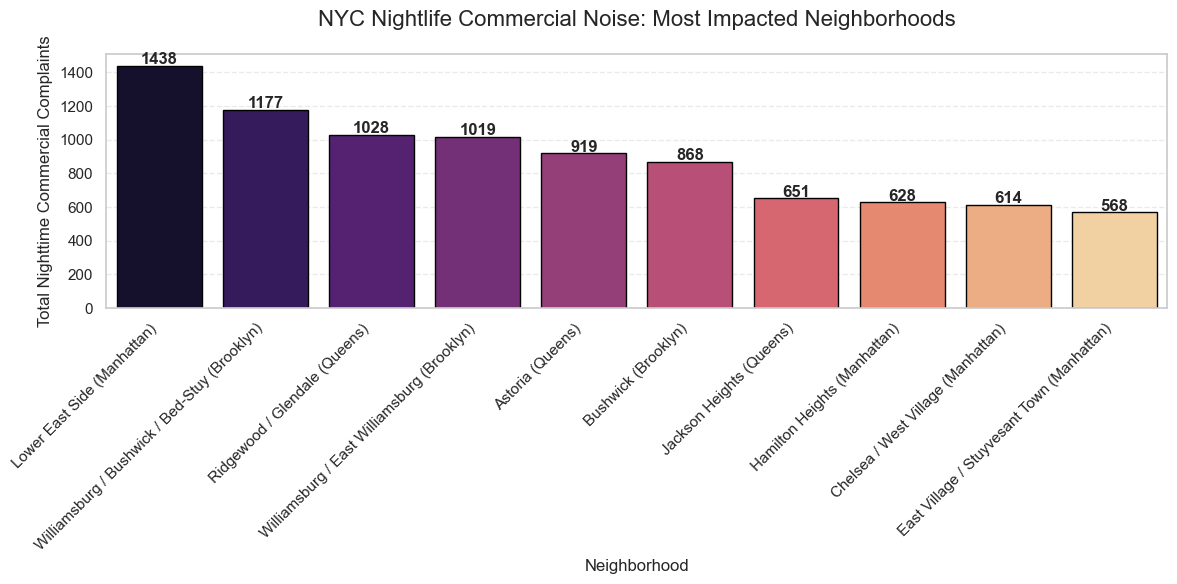

In [12]:
# The Final Visual
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_df,
    x='Neighborhood', 
    y='Complaint Count', 
    hue='Neighborhood',  # Assigning hue to the x variable to satisfy the warning
    palette='magma', 
    edgecolor='black',
    legend=False            # Hiding the legend since the colors are just for style
)



plt.xticks(rotation=45, ha='right')
plt.title('NYC Nightlife Commercial Noise: Most Impacted Neighborhoods', fontsize=16, pad=20)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Total Nighttime Commercial Complaints', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)


# Add data labels on top of bars
for i, v in enumerate(top_10_zips.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

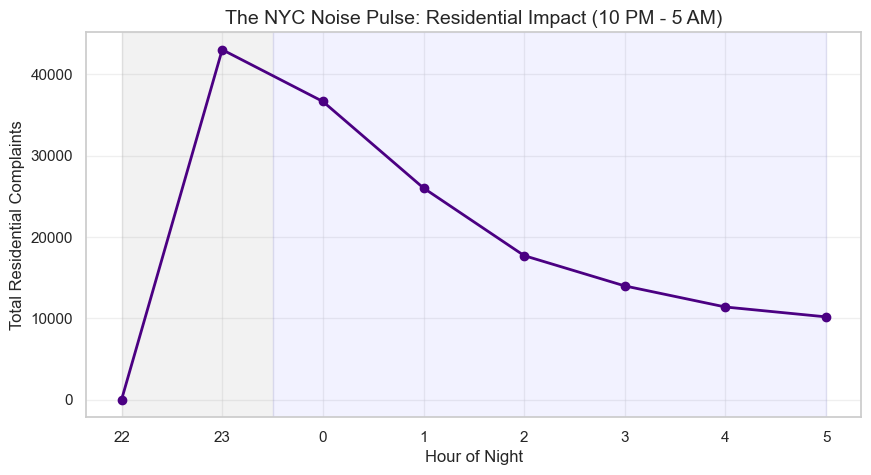

In [13]:
# 1. Creating 'Hour' column for Residential data
night_hours = [22, 23, 0, 1, 2, 3, 4, 5]

# Filtering the 'night_noise' dataframe we already created for Residential only
res_noise_pulse = night_noise[night_noise['complaint_type'] == 'Noise - Residential'].copy()
res_noise_pulse['Hour'] = pd.to_datetime(res_noise_pulse['created_date']).dt.hour

# 2. Grouping by hour to see the Residential 'Noise Pulse'
res_noise_pulse['Hour'] = pd.Categorical(res_noise_pulse['Hour'], categories=night_hours, ordered=True)
res_hourly_trend = res_noise_pulse.groupby('Hour', observed=True).size().reindex(night_hours, fill_value=0)

# 3. Plotting the Residential Pulse
plt.figure(figsize=(10, 5))
plt.plot(range(len(night_hours)), res_hourly_trend.values, marker='o', color='indigo', linewidth=2)

plt.title('The NYC Noise Pulse: Residential Impact (10 PM - 5 AM)', fontsize=14)
plt.xlabel('Hour of Night', fontsize=12)
plt.ylabel('Total Residential Complaints', fontsize=12)
plt.xticks(range(len(night_hours)), night_hours)
plt.grid(True, alpha=0.3)

# Shading for context
plt.axvspan(0, 1.5, color='gray', alpha=0.1, label='Pre-Midnight')
plt.axvspan(1.5, 7, color='blue', alpha=0.05, label='Deep Night')

plt.show()

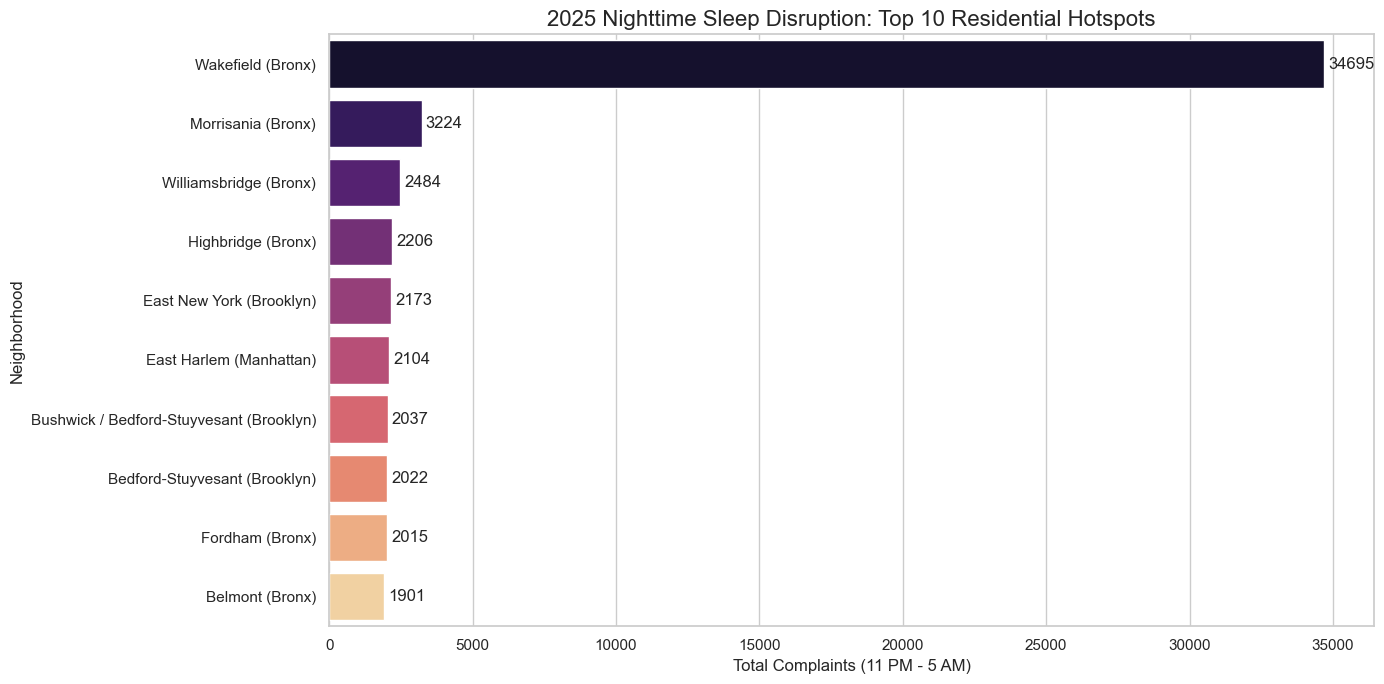

In [21]:


# 1. Map the Residential Hotspots to Neighborhood Names

# 2. Filter and Clean the Data
res_noise = night_noise[night_noise['complaint_type'] == 'Noise - Residential'].copy()
res_noise['incident_zip'] = res_noise['incident_zip'].astype(str).str.replace('.0', '', regex=False)

# 3. Get the Top 10 and apply the mapping
top_10_res = res_noise['incident_zip'].value_counts().head(10).reset_index()
top_10_res.columns = ['zip', 'count']
top_10_res['neighborhood'] = top_10_res['zip'].map(neighborhood_map)

# 4. Plot the results
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=top_10_res, x='count', y='neighborhood', hue= 'neighborhood', palette='magma')

# Add values on the bars for clarity
for i in ax.containers:
    ax.bar_label(i, padding=3)

plt.title('2025 Nighttime Sleep Disruption: Top 10 Residential Hotspots', fontsize=16)
plt.xlabel('Total Complaints (11 PM - 5 AM)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()

# Save for your portfolio
plt.savefig('residential_noise_bar_2025.png')
plt.show()

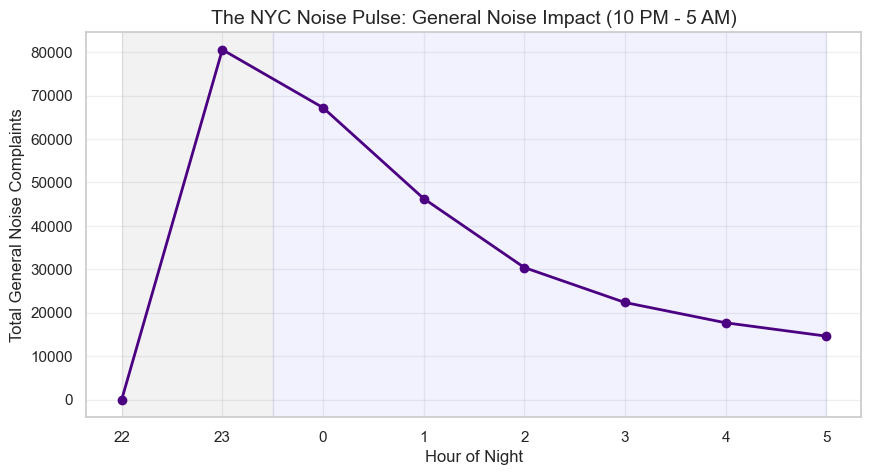

In [15]:
# 1. Creating 'Hour' column for General Night data
night_hours = [22, 23, 0, 1, 2, 3, 4, 5]

# Filtering the 'night_noise' dataframe we already created for Residential only
gen_noise_pulse = night_noise.copy()
gen_noise_pulse['Hour'] = pd.to_datetime(gen_noise_pulse['created_date']).dt.hour

# 2. Grouping by hour to see the Residential 'Noise Pulse'
gen_noise_pulse['Hour'] = pd.Categorical(gen_noise_pulse['Hour'], categories=night_hours, ordered=True)
gen_hourly_trend = gen_noise_pulse.groupby('Hour', observed=True).size().reindex(night_hours, fill_value=0)

# 3. Plotting the Residential Pulse
plt.figure(figsize=(10, 5))
plt.plot(range(len(night_hours)), gen_hourly_trend.values, marker='o', color='indigo', linewidth=2)

plt.title('The NYC Noise Pulse: General Noise Impact (10 PM - 5 AM)', fontsize=14)
plt.xlabel('Hour of Night', fontsize=12)
plt.ylabel('Total General Noise Complaints', fontsize=12)
plt.xticks(range(len(night_hours)), night_hours)
plt.grid(True, alpha=0.3)

# Shading for context
plt.axvspan(0, 1.5, color='gray', alpha=0.1, label='Pre-Midnight')
plt.axvspan(1.5, 7, color='blue', alpha=0.05, label='Deep Night')

plt.show()

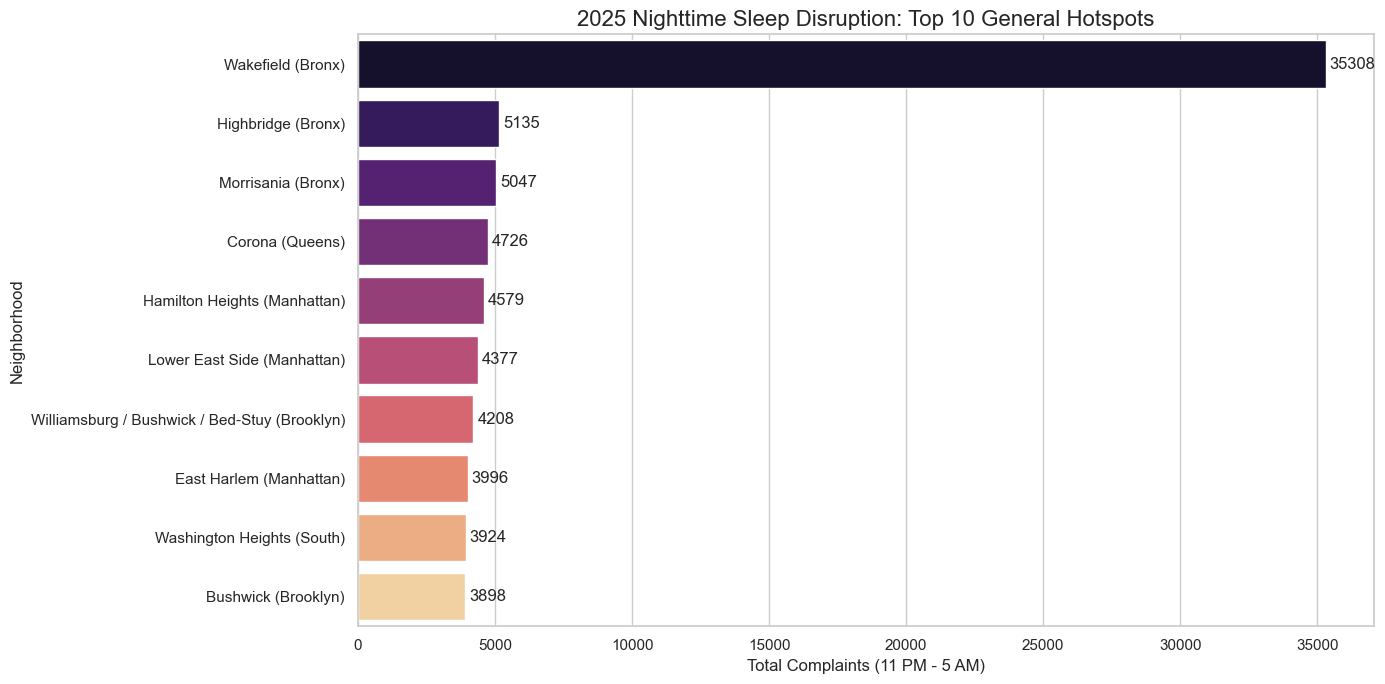

In [22]:


# 1. Map the General NIght Hotspots to Neighborhood Names

# 2. Filter and Clean the Data

gen_noise_pulse['incident_zip'] = gen_noise_pulse['incident_zip'].astype(str).str.replace('.0', '', regex=False)

# 3. Get the Top 10 and apply the mapping
top_10_gen = gen_noise_pulse['incident_zip'].value_counts().head(10).reset_index()
top_10_gen.columns = ['zip', 'count']
top_10_gen['neighborhood'] = top_10_gen['zip'].map(neighborhood_map)

# 4. Plot the results
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=top_10_gen, x='count', y='neighborhood', hue='neighborhood', palette='magma')

# Add values on the bars for clarity
for i in ax.containers:
    ax.bar_label(i, padding=3)

plt.title('2025 Nighttime Sleep Disruption: Top 10 General Hotspots', fontsize=16)
plt.xlabel('Total Complaints (11 PM - 5 AM)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()

# Save for your portfolio
plt.savefig('general_noise_bar_2025.png')
plt.show()

In [17]:
# 1. Initialize the map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='CartoDB dark_matter')

# 2. Extract coordinates from your 'res_noise_pulse' (The North Bronx Story)
res_heat_data = [[row['latitude'], row['longitude']] for _, row in res_noise_pulse.dropna(subset=['latitude', 'longitude']).iterrows()]

# 3. Extract coordinates from your 'comm_noise' (The Manhattan/Nightlife Story)
comm_heat_data = [[row['latitude'], row['longitude']] for _, row in comm_noise.dropna(subset=['latitude', 'longitude']).iterrows()]

# 4. Add the Residential Heat Layer (High Intensity Red)
HeatMap(
    res_heat_data, 
    radius=12, 
    blur=18, 
    name="Residential Pulse (Focus: North Bronx)",
    gradient={0.4: '#6a0000', 0.6: '#d73027', 0.7: '#f46d43', 1: '#fee08b'}
).add_to(m)

# 5. Add the Commercial Heat Layer (Distinctive Purple/Gold)
HeatMap(
    comm_heat_data, 
    radius=10, 
    blur=15, 
    name="Commercial Pulse (Focus: Business/Nightlife)",
    gradient={0.4: '#3f007d', 0.6: '#6a51a3', 0.8: '#4292c6', 1.0: '#7fffd4'}
).add_to(m)


# 5. THE MACRO: Add the Interactive Legend
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 220px; height: 160px; 
    background-color: rgba(255, 255, 255, 0.85);
    z-index:9999; font-size:14px;
    border:2px solid grey; border-radius:6px;
    padding: 10px;
    font-family: 'Arial', sans-serif;
    ">
    <b>Noise Intensity Legend</b><br>
    
    <p style="margin-top:10px; margin-bottom:5px;"><b>Residential (Fire)</b></p>
    <div style="background: linear-gradient(to right, #6a0000, #d73027, #f46d43, #fee08b); 
                width: 100%; height: 15px; border-radius:3px;"></div>
    <span style="font-size:10px;">Low</span> <span style="font-size:10px; float:right;">Extreme</span>

    <p style="margin-top:10px; margin-bottom:5px;"><b>Commercial (Neon)</b></p>
    <div style="background: linear-gradient(to right, #3f007d, #6a51a3, #4292c6, #7fffd4); 
                width: 100%; height: 15px; border-radius:3px;"></div>
    <span style="font-size:10px;">Low</span> <span style="font-size:10px; float:right;">High</span>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# 6. Add a Toggle for Comparison
folium.LayerControl().add_to(m)

m.save('NYC_Analysis_Heatmap_2025.html')
m

In [18]:
# Check the earliest and latest dates in your data
print(f"Start Date: {df_2025['created_date'].min()}")
print(f"End Date: {df_2025['created_date'].max()}")


Start Date: 2025-01-01 00:00:12
End Date: 2025-12-31 23:59:28


In [19]:
print(f"Total rows in 2025: {len(df_new)}")

Total rows in 2025: 833000
